In [173]:
######### MODULES ##########
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from PIL import Image
from scipy import interpolate as spinter, ndimage as spimg, signal as spsig
plt.rcParams.update({'font.size':14})
np.set_printoptions(threshold=sys.maxsize)

In [174]:
###########SHINY NEW FUNCTIONS###############

def flatten_2d_list(bookshelf):
    return [page for book in bookshelf for page in book]

def flatten_3d_list(library): #Would be nice to know the number of dimentions of a list. This is not easy. :( I can only use np.arrays if the list is 'rectangular'.
    return [page for bookshelf in library for book in bookshelf for page in book]

def roll_average(xs, ys, window_width, number_of_points= 100):
    xs = flatten_3d_list(xs)
    ys = flatten_3d_list(ys)
    points = np.linspace(np.nanmin(xs), np.nanmax(xs), number_of_points)
    average = []
    uncertainty = []
    
    for point in points:
        points_in_window = [ys[n] for n, x in enumerate(xs) if x-window_width < point and point < x+window_width] #create a list of points inside the window
        average = average + [np.nanmean(points_in_window)]
        uncertainty = uncertainty + [np.nanstd(points_in_window)]

    return points, average, uncertainty

def read_metadata(requested_data): #NOT IDIOT PROOF. BE CAREFUL WHEN USING
    shot_list = ["SHOT #","Date","Time","Purpose","Target X","Target Y","Target Z","Wheel XPS","position on wheel","TARGET NUMBER","Laser Energy (before comp) [J]","Laser duration [fs]","Horiz ns/div","Trigger val [mV]","C1 [V/div]","C2 [V/div]","C3 [V/div]","C4 [V/div]","C1 att [dB]","C2 att [dB]","C3 att [dB]","C1 diag","C2 diag","C3 diag","C4 diag","Comments JLD scope","THz comments","Column2","X-ray comments","Column3","Column4","Column5"]
    target_list = ["Date","Number","Position in the box","Wheel","Position on the wheel","Rotation angle(TARGET)","XYZ (TARGET)","Thickness (um)","Length(mm)","Material","Type","Comments"]

    if requested_data[0] in shot_list : sheet, header_row = "Shot-list", 1 # weird python syntax
    if requested_data[0] in target_list : sheet, header_row = "Target list", 0

    dataframe = pd.read_excel(io= "organised_data\\Shots_Targets_Diagnostics.xlsx", # numpy is bad at reading excel files.
                              sheet_name= sheet,
                              header= header_row,
                              usecols= requested_data)
    
    dictionary = dataframe.to_dict(orient= "list")
    #dictionary = {key: np.array(dataframe[key]) for key in dataframe.columns} # pandas doesn't have a `dataframe.to_dict(orient= "array")`

    return dictionary

def open_pyro_oscilloscope(requested_data, shots, file_directories, file_names, silent= True):
        channel = "Ch1" if requested_data == "pyro_time" else requested_data
        regex_code = ".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*"+channel+".csv"
        match = [bool(re.findall(regex_code, file_name)) for file_name in file_names]
        filtered_file_directories = file_directories[match]
        filtered_file_names = file_names[match]
        number_of_files = len(filtered_file_names)
        filtered_file_paths = [os.path.join(filtered_file_directories[n],filtered_file_names[n]) for n in range(number_of_files)]
                               
        shot_no = [int(re.search(regex_code, filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
        pyro_data = [np.genfromtxt(filtered_file_path, delimiter=',', skip_header =0, usecols= 3 if requested_data == "pyro_time" else 4) for filtered_file_path in filtered_file_paths]

        if not silent: # remember to do silent == True if you use read_data in a loop
            print("Found {:d} files:".format(len(filtered_file_names)))
            [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

        return shot_no, pyro_data

def read_diagnostic_data(requested_data, silent= False):
    data_path = "organised_data\\"
    dictionary = {"shot":[]}
    emp_oscilloscope_data = ["time","bdot","tof","diode"]
    pyro_oscilloscope_data = ["Ch1","Ch2","Ch3","Ch4","pyro_time"]

    all_file_directories = [root for root, dirs, files in os.walk(data_path) for file in files]
    all_file_directories = np.array(all_file_directories)
    all_file_names = [file for root, dirs, files in os.walk(data_path) for file in files]
    all_file_names = np.array(all_file_names)
    requested_data = {ch: [str(int(shot)) for shot in shots] for ch, shots in requested_data.items()} # ensure that all shot numbers are strings of ints. floats will screw up re.

    for request, shots in requested_data.items():
        if request in pyro_oscilloscope_data:
            new_shots, new_data = open_pyro_oscilloscope(request, shots, all_file_directories, all_file_names, silent= silent)
        else:
            new_shots, new_data = [], []
            print("WARNING!! {0} is not a recognised data type.".format(request))

        old_shots = dictionary["shot"]
        union_shots = np.unique(old_shots + new_shots).tolist()

        dictionary = {diagnostic: [readings[old_shots.index(shot)] if shot in old_shots else np.nan for shot in union_shots] for diagnostic, readings in dictionary.items()} #rearrange the existing data to corrispond with its respective shot
        dictionary[request] = [new_data[new_shots.index(shot)] if shot in new_shots else np.nan for shot in union_shots] # List comprehention gives me headaches. Add the new data to it's respective shot. pandas might be better for this.
        dictionary["shot"] = union_shots #add the new shots

    return dictionary

In [175]:
shotsheet = read_metadata(["SHOT #","Target X","Target Z","TARGET NUMBER"])
targetsheet = read_metadata(["Number","Wheel"])

total_number_of_shots = len(shotsheet["SHOT #"])

shotsheet["Target X"] = np.array([np.nan if re.search('[^\d.]', str(x)) else float(x) for x in shotsheet["Target X"]]) # remove all invalid data. Including 200um, ???, ect.
shotsheet["Target Z"] = np.array([np.nan if re.search('[^\d.]', str(z)) else float(z) for z in shotsheet["Target Z"]]) # '[^\d.]' matches all non-numeric characters. Numeric characters being: `0123456789.`

shotsheet["Wheel"] = [targetsheet["Wheel"][targetsheet["Number"].index(target_number)] if target_number in targetsheet["Number"] else np.nan for target_number in shotsheet["TARGET NUMBER"]] # give each target it's respective wheel. 


###Initialisation
target = 0
shotsheet["relative X"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
shotsheet["relative Z"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
###Loop over all shots
for n in range(total_number_of_shots):
    if shotsheet["TARGET NUMBER"][n] != target:
        delta_x = shotsheet["Target X"][n]
        delta_z = shotsheet["Target Z"][n]
        target = shotsheet["TARGET NUMBER"][n] # ASSUMES THAT WE DON'T RETURN BACK TO THE SAME TARGET.

    shotsheet["relative X"][n] = shotsheet["Target X"][n] -delta_x
    shotsheet["relative Z"][n] = shotsheet["Target Z"][n] -delta_z

shotsheet["d"] = np.linalg.norm([shotsheet["relative X"], shotsheet["relative Z"]], axis= 0) # pythagorus to find d. This might be a little simplistic since we know the angle should be 25°

pd.DataFrame(shotsheet)

,SHOT #,Target X,Target Z,TARGET NUMBER,Wheel,relative X,relative Z,d
0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN
1,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN
2,3.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN
3,4.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN
4,5.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
262,262.0,3.845,5.65,125.0,7.0,1.5,0.75,1.677051
263,263.0,4.445,5.97,125.0,7.0,2.1,1.07,2.356884
264,264.0,5.045,6.32,125.0,7.0,2.7,1.42,3.050639
265,265.0,5.745,6.72,125.0,7.0,3.4,1.82,3.856475


In [185]:
targets = {"Ch2": [66,69,81,86,90,91,105,106,108,115],
           "Ch3": [66,67,69,90,105,106,115]}

shots = {ch: [shotsheet["SHOT #"][n] for t in target for n in range(total_number_of_shots) if shotsheet["TARGET NUMBER"][n] == t] for ch, target in targets.items()} #find the respective shots for these targets

pyro = read_diagnostic_data(shots, silent= True)
pyro = {key: [np.abs(np.nanmin(ch)) for ch in pyro[key]] if key != "shot" else pyro["shot"] for key in pyro.keys()} #find the minima of every channel

for key in pyro.keys():
    if key != "shot":
        shotsheet[key] = [pyro[key][pyro["shot"].index(shot)] if shot in pyro["shot"] else np.nan for shot in shotsheet["SHOT #"]] #add channel minima to the shotsheet on respective shot numbers

#shotsheet = {key: np.array(shotsheet[key]) for key in shotsheet.keys()} #make all shotsheet dict values into arrays.

pd.DataFrame(shotsheet)

C:\Users\syf83691\AppData\Local\Temp\ipykernel_26040\4052628855.py:7: RuntimeWarning: All-NaN axis encountered
  pyro = {key: [np.abs(np.nanmin(ch)) for ch in pyro[key]] if key != "shot" else pyro["shot"] for key in pyro.keys()} #find the minima of every channel


,SHOT #,Target X,Target Z,TARGET NUMBER,Wheel,relative X,relative Z,d,Ch2,Ch3
0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,3.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,5.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
262,262.0,3.845,5.65,125.0,7.0,1.5,0.75,1.677051,NaN,NaN
263,263.0,4.445,5.97,125.0,7.0,2.1,1.07,2.356884,NaN,NaN
264,264.0,5.045,6.32,125.0,7.0,2.7,1.42,3.050639,NaN,NaN
265,265.0,5.745,6.72,125.0,7.0,3.4,1.82,3.856475,NaN,NaN


In [178]:
flat_targets = np.unique(flatten_2d_list(targets.values())) #create a list of targets without channel infomation

### initialise
dataset = {}
dataset["d"] = [[shotsheet["d"][n] for n in range(total_number_of_shots) if shotsheet["TARGET NUMBER"][n] == target] for target in flat_targets] # displacement must also be initialised because it determines which data sets are valid

### loop over all other data sets
for key in shotsheet.keys():
    if key != "d":
        dataset[key] = [[shotsheet[key][n] for n in range(total_number_of_shots) if shotsheet["TARGET NUMBER"][n] == target] for target in flat_targets] #change shape so that shots on the same target are grouped together
        dataset[key] = [target for m, target in enumerate(dataset[key]) if len(dataset["d"][m]) > 0] #filter out targets with no displacement data. (targets that were never shot)
    if key in ["TARGET NUMBER","Wheel"]:
        dataset[key] = [target[0] for target in dataset[key]] #these do not change when the target number is constant. Remove list.

### finalise
dataset["d"] = [target for target in dataset["d"] if len(target) > 0]

pd.DataFrame(dataset)

,d,SHOT #,Target X,Target Z,TARGET NUMBER,Wheel,relative X,relative Z,Ch2,Ch3
0,"[0.0, 0.578013840664737, 1.0295630140987, 1.53...","[128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134...","[1.255, 1.755, 2.155, 2.655, 3.155, 3.555, 3.9...","[6.52, 6.81, 7.02, 7.15, 7.31, 7.49, 7.65, nan]",66.0,4.0,"[0.0, 0.5, 0.8999999999999999, 1.4, 1.9, 2.300...","[0.0, 0.29000000000000004, 0.5, 0.630000000000...","[0.499999992, 0.259999992, 0.339999992, 0.3199...","[6.32, 4.56, 2.4, 3.36, 2.96, 2.88, 2.8, 2.4]"
1,"[0.0, 0.5192301994298869, 1.0332473082471594, ...","[122.0, 123.0, 124.0, 125.0, 126.0, 127.0]","[2.205, 2.705, 3.205, 3.705, 4.105, 4.605]","[5.81, 5.95, 6.07, 6.24, 6.39, 6.52]",67.0,4.0,"[0.0, 0.5, 1.0, 1.5, 1.9000000000000004, 2.400...","[0.0, 0.14000000000000057, 0.2600000000000007,...","[nan, nan, nan, nan, nan, nan]","[5.2, 4.8, 5.36, 3.12, 4.08, 2.0]"
2,"[0.0, 0.4614108798023728, 0.8899999999999997, ...","[114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120...","[1.705, 2.105, 2.505, 3.005, 3.405, 3.805, 4.2...","[5.54, 5.77, 5.93, 6.13, 6.31, 6.5, 6.68, 6.85]",69.0,4.0,"[0.0, 0.3999999999999999, 0.7999999999999998, ...","[0.0, 0.22999999999999954, 0.3899999999999997,...","[0.519999992, 0.379999992, 0.559999992, 0.4599...","[4.6, 5.08, 4.0, 1.84, 4.56, 3.28, 2.72, 2.8]"
3,"[0.0, 0.51, 1.0427847332982967, 1.673140759171...","[137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0]","[1.965, 2.415, 2.915, 3.515, 4.015, 4.515, 5.015]","[4.96, 5.2, 5.39, 5.59, 5.76, 5.93, 6.125]",81.0,5.0,"[0.0, 0.44999999999999996, 0.95, 1.55, 2.05, 2...","[0.0, 0.2400000000000002, 0.4299999999999997, ...","[0.419999992, 0.379999992, 0.419999992, 0.3999...","[nan, nan, nan, nan, nan, nan, nan]"
4,"[0.0, 0.5706356105256665, 1.021334910790775, 1...","[147.0, 148.0, 149.0, 150.0, 151.0]","[2.405, 2.905, 3.355, 3.855, 4.355]","[5.79, 6.065, 6.165, 6.325, 6.455]",86.0,5.0,"[0.0, 0.5, 0.9500000000000002, 1.4500000000000...","[0.0, 0.27500000000000036, 0.375, 0.5350000000...","[0.499999992, 0.259999992, 0.419999992, 0.3599...","[nan, nan, nan, nan, nan]"
5,"[0.0, 0.4517742799230606, 0.9058835465996716, ...","[206.0, 207.0, 208.0, 209.0, 210.0, 211.0, 212.0]","[1.995, 2.395, 2.795, 3.195, 3.595, 3.995, 4.395]","[5.82, 6.03, 6.245, 6.445, 6.625, 6.76, 6.92]",90.0,6.0,"[0.0, 0.3999999999999999, 0.7999999999999998, ...","[0.0, 0.20999999999999996, 0.4249999999999998,...","[3.24, 3.24, 3.68, 6.24, 2.76, 0.44, nan]","[0.36, 0.48, 0.36, 0.32, 0.32, 0.28, nan]"
6,"[0.0, 0.1640121946685672, 0.509141434181112, 0...","[213.0, 214.0, 215.0, 216.0, 217.0, 218.0, 219...","[2.295, 2.395, 2.695, 2.895, 3.395, 3.795, 4.1...","[5.445, 5.575, 5.76, 5.87, 6.115, 6.315, 6.505...",91.0,6.0,"[0.0, 0.10000000000000009, 0.3999999999999999,...","[0.0, 0.1299999999999999, 0.3149999999999995, ...","[nan, 0.2, 0.28, 0.52, 0.36, 0.36, 0.4, 0.36, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan]"
7,"[0.0, 0.5682429058070146, 1.0344563789739998, ...","[178.0, 179.0, 180.0, 181.0, 182.0, 183.0]","[1.475, 1.975, 2.375, 2.875, 3.375, 4.775]","[5.57, 5.84, 6.08, 6.38, 6.66, 7.42]",105.0,6.0,"[0.0, 0.5, 0.8999999999999999, 1.4, 1.9, 3.300...","[0.0, 0.2699999999999996, 0.5099999999999998, ...","[3.12, 2.56, 3.36, 1.96, 4.24, 0.48]","[1.8, 1.64, 1.88, 1.16, 1.8, 0.44]"
8,"[0.0, 0.4664761515876243, 0.8989438247187642, ...","[184.0, 185.0, 186.0, 187.0, 188.0, 189.0, 190.0]","[1.675, 2.075, 2.475, 2.875, 3.375, 3.875, 4.275]","[6.01, 6.25, 6.42, 6.6, 6.8, 7.04, 7.23]",106.0,6.0,"[0.0, 0.40000000000000013, 0.8, 1.2, 1.7, 2.2,...","[0.0, 0.2400000000000002, 0.41000000000000014,...","[2.68, 1.36, 1.88, 1.68, 1.56, 1.16, 0.72]","[2.64, 1.84, 2.28, 2.24, 1.76, 1.28, 0.56]"
9,"[0.0, 0.4664761515876236, 0.8989438247187636, ...","[197.0, 198.0, 199.0, 200.0, 201.0, 202.0, 203...","[2.475, 2.875, 3.275, 3.675, 4.075, 4.475, 4.8...","[4.98, 5.22, 5.39, 5.59, 5.81, 5.99, 6.175, 6....",108.0,6.0,"[0.0, 0.3999999999999999, 0.7999999999999998, ...","[0.0, 0.23999999999999932, 0.40999999999999925...","[0.88, 0.8, 0.76

In [179]:
### initialise
peaks, peak_heights = {}, {}

### loop over all channels
for ch in targets.keys():
    dataset[ch] = [np.array(target)/np.nanmax(target) for target in dataset[ch]] #normalise all channels (to 1)
    
    peaks[ch] = [spsig.find_peaks(target)[0] for target in dataset[ch]] #find the index location of every peak in every target
    peaks[ch] = [[dataset["d"][target][peak] for peak in peaks] for target, peaks in enumerate(peaks[ch])] #convert from index to mm
    peak_heights[ch] = [spsig.find_peaks(target, height= -np.inf)[1]["peak_heights"] for target in dataset[ch]] #find voltage of every maxima

    

C:\Users\syf83691\AppData\Local\Temp\ipykernel_26040\1573355977.py:6: RuntimeWarning: All-NaN axis encountered
  dataset[ch] = [np.array(target)/np.nanmax(target) for target in dataset[ch]] #normalise all channels (to 1)


In [180]:
rolling_width = 0.3 #half width
number_of_rolling_points = 100

rolling_points, rolling_average, rolling_uncertainty = roll_average([dataset["d"] for ch in targets.keys()], [dataset[ch] for ch in targets.keys()], rolling_width, number_of_rolling_points)

In [181]:
peaks

{'Ch2': [[1.0295630140987],
  [],
  [0.8899999999999997],
  [1.0427847332982967, 2.7282595184476124],
  [1.021334910790775],
  [1.3530059127734806],
  [0.7352720584926371, 2.1756838005555865],
  [1.0344563789739998, 2.190456573411123],
  [0.8989438247187642],
  [1.3461426373159713, 2.2405579662218065, 3.0345057258143373],
  [1.6077624202599088]],
 'Ch3': [[1.5352198539622919],
  [1.0332473082471594, 1.9865548066942431],
  [0.4614108798023728, 1.8662529303392932],
  [],
  [],
  [0.4517742799230606],
  [],
  [1.0344563789739998, 2.190456573411123],
  [0.8989438247187642],
  [],
  [1.6077624202599088]]}

In [182]:
peak_heights

{'Ch2': [array([0.67999999]),
  array([], dtype=float64),
  array([1.]),
  array([1.       , 0.9047619]),
  array([0.84]),
  array([1.]),
  array([1.        , 0.76923077]),
  array([0.79245283, 1.        ]),
  array([0.70149254]),
  array([1.        , 0.56521739, 0.56521739]),
  array([0.76041667])],
 'Ch3': [array([0.53164557]),
  array([1.        , 0.76119403]),
  array([1.       , 0.8976378]),
  array([], dtype=float64),
  array([], dtype=float64),
  array([1.]),
  array([], dtype=float64),
  array([1.        , 0.95744681]),
  array([0.86363636]),
  array([], dtype=float64),
  array([0.85714286])]}

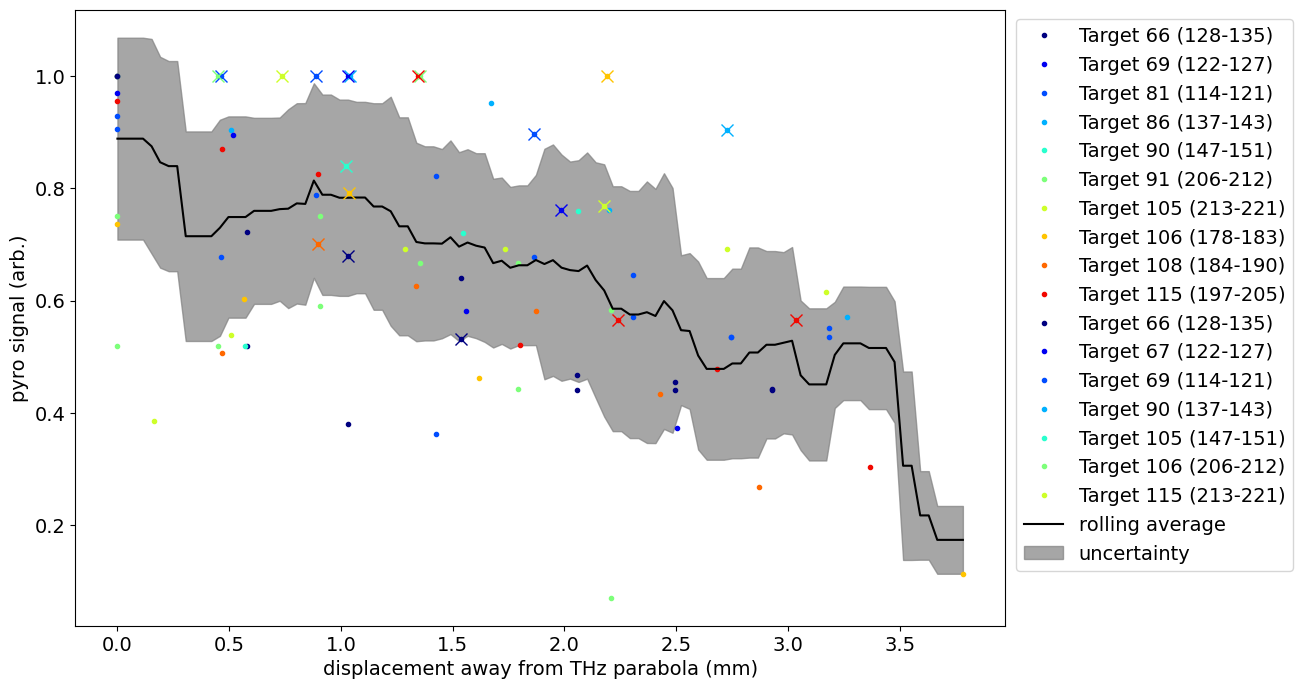

In [184]:
number_of_targets = len(dataset["TARGET NUMBER"])

colourmap = plt.get_cmap('jet')
colourvalue = np.linspace(0, 1, number_of_targets)
colours = [colourmap(value) for value in colourvalue] #openai did this bit for me.

####BIG PLOT!!####

fig, axs = plt.subplots(figsize= (12,8))

[axs.plot(dataset["d"][n],
          dataset[ch][n],
          color= colours[n],
          label= "Target {0:d} ({1:d}-{2:d})".format(int(t), int(dataset["SHOT #"][n][0]), int(dataset["SHOT #"][n][-1])),
          marker = ".",
          linestyle= "None")
          for ch, target in targets.items()
          for n, t in enumerate(target)]

axs.plot(rolling_points,
        rolling_average,
        color= "k",
        label= "rolling average")
axs.fill_between(rolling_points,
                 np.subtract(rolling_average, rolling_uncertainty),
                 np.add(rolling_average, rolling_uncertainty),
                 color= "gray",
                 alpha= 0.7,
                 label= "uncertainty")

[axs.plot(peaks[ch][n],
          peak_heights[ch][n],
          marker= "x",
          markersize= 8,
          linestyle= "None",
          color= colours[n])
          for ch, target in targets.items()
          for n, t in enumerate(target)]

axs.set(xlabel= "displacement away from THz parabola (mm)", ylabel= "pyro signal (arb.)")

plt.legend(loc= "upper right", bbox_to_anchor=(1.32, 1))
#plt.ylim(0,1.25)
plt.show()